In [7]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi

In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_3^{(0.5)}$

In [8]:
reco='recoJet_tau_0p5_2_nom_dijetSel'
gen='genJet_tau_0p5_2_dijetSel'
response='respJet_tau_0p5_2_nom_dijetSel'

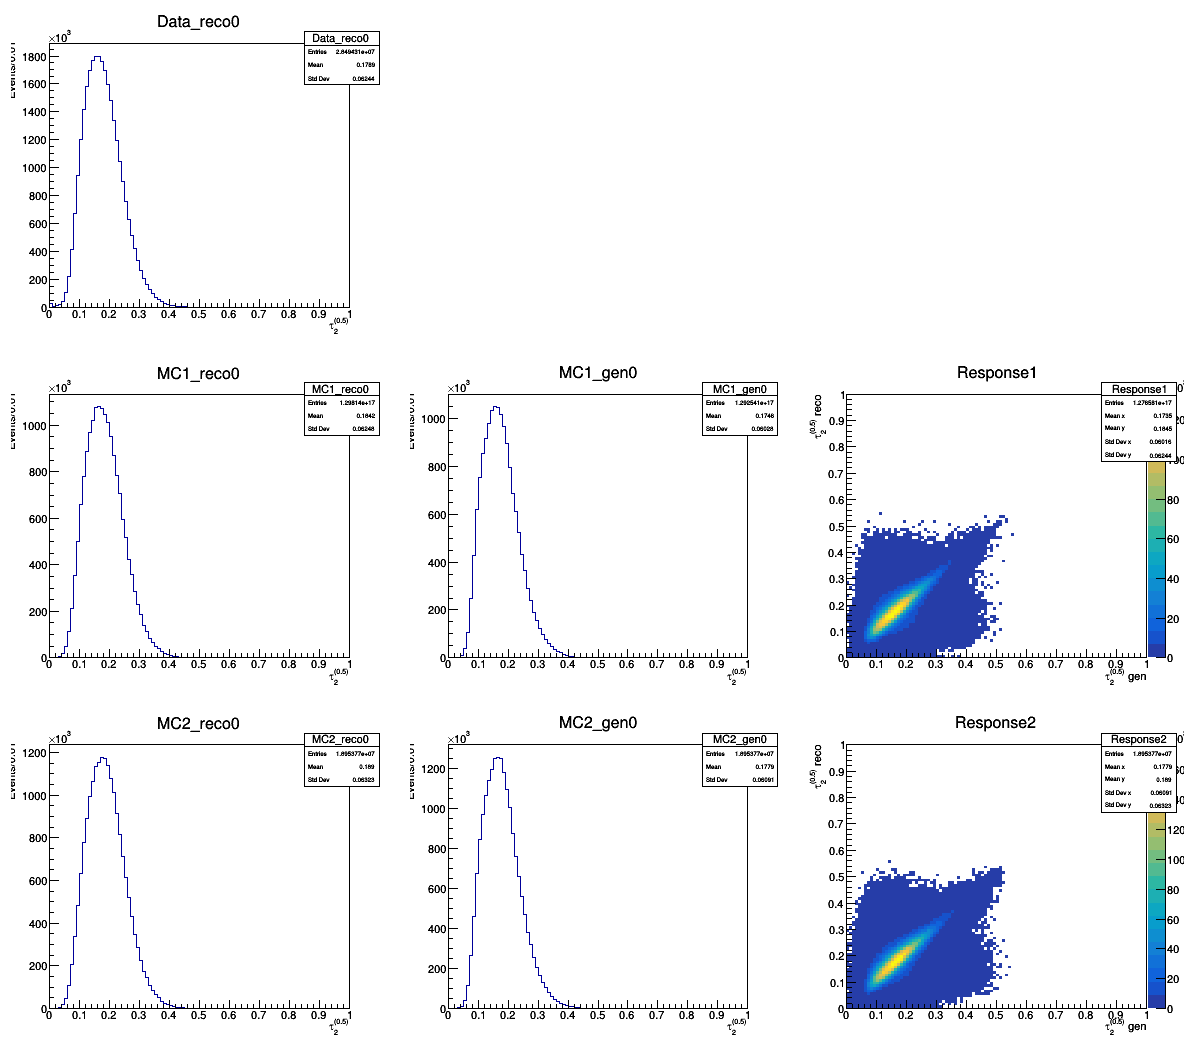

In [9]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

# Different bins

In [10]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 978.716548012 1916.87702133
0.015 318.317574129 911.367528001
0.025 619.697500741 2220.4970749
0.035 2720.93838136 6632.88832503
0.045 10160.5203524 17164.3611204
0.055 38754.5880546 47381.2344688
0.065 116688.271786 107727.673411
0.075 265577.921904 207613.24743
0.085 458940.132447 338301.198019
0.095 674736.424435 480886.24449
0.105 847175.104854 631103.882147
0.115 968703.158436 775959.190051
0.125 1067729.3968 888960.630206
0.135 1141988.75526 994686.494852
0.145 1198184.35588 1062353.43038
0.155 1251206.33603 1133841.13709
0.165 1256560.10549 1154616.06268
0.175 1250386.46934 1177102.72095
0.185 1180347.78463 1170160.42338
0.195 1098114.1081 1137682.49774
0.205 1006046.22361 1075830.79894
0.215 873809.823996 1011928.2792
0.225 759055.784732 912106.840871
0.235 661041.11864 813878.927123
0.245 559629.270244 714730.762949
0.255 469515.593729 614282.659371
0.265 381279.505922 520122.746801
0.275 320473.133325 432017.929259
0.285 256527.199493 346458.472158
0.295 204506.363354 2

In [18]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.56])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.48,0.56])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.56])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.48,0.56])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.56])))
reco_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.47,0.56])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.56])))
reco_bins1=np.array([x for x in np.linspace(num=21,start=0,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.48,0.56])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=21,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.56])))
reco_bins1=np.array([x for x in np.linspace(num=41,start=0.,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.48,0.56])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.1  0.2  0.3  0.4  0.56] 5
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.48 0.56] 10
[0.   0.08 0.16 0.24 0.32 0.4  0.56] 6
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.48 0.56] 12
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.56] 7
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.47
 0.56] 14
0.0,0.06,0.12,0.18,0.24,0.3,0.36,0.56
0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.32999999999999996,0.36,0.47,0.56
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.56] 11
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.48 0.56] 22
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.56] 21
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.48
 0.56] 42


In [13]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(0.5)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(0.5)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(0.5)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.1  0.2  0.3  0.4  0.56]
for binning 2
[0.   0.08 0.16 0.24 0.32 0.4  0.56]
for binning 3
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.56]
for binning 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.56]
for binning 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.56]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 10 input bins and 5 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #6 (xaxis:#tau_{2}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 10 input bins and 5 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #6 (xaxis:#tau_{2}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in

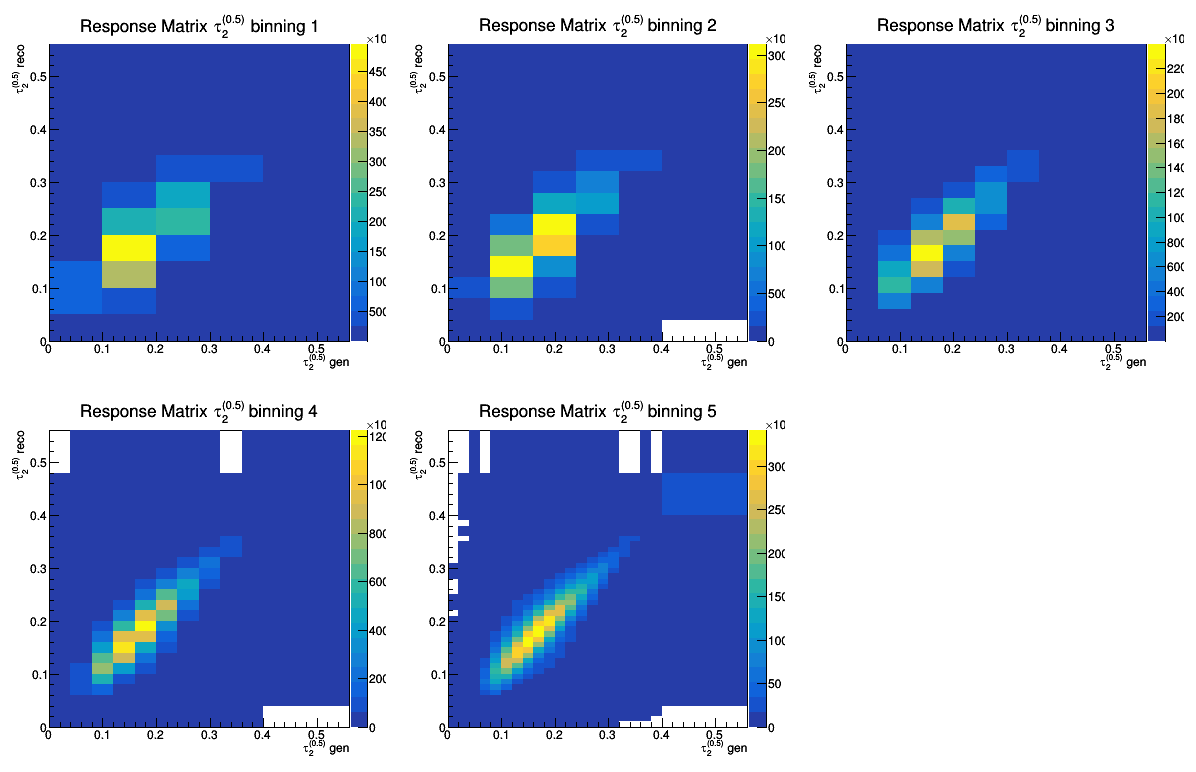

In [14]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


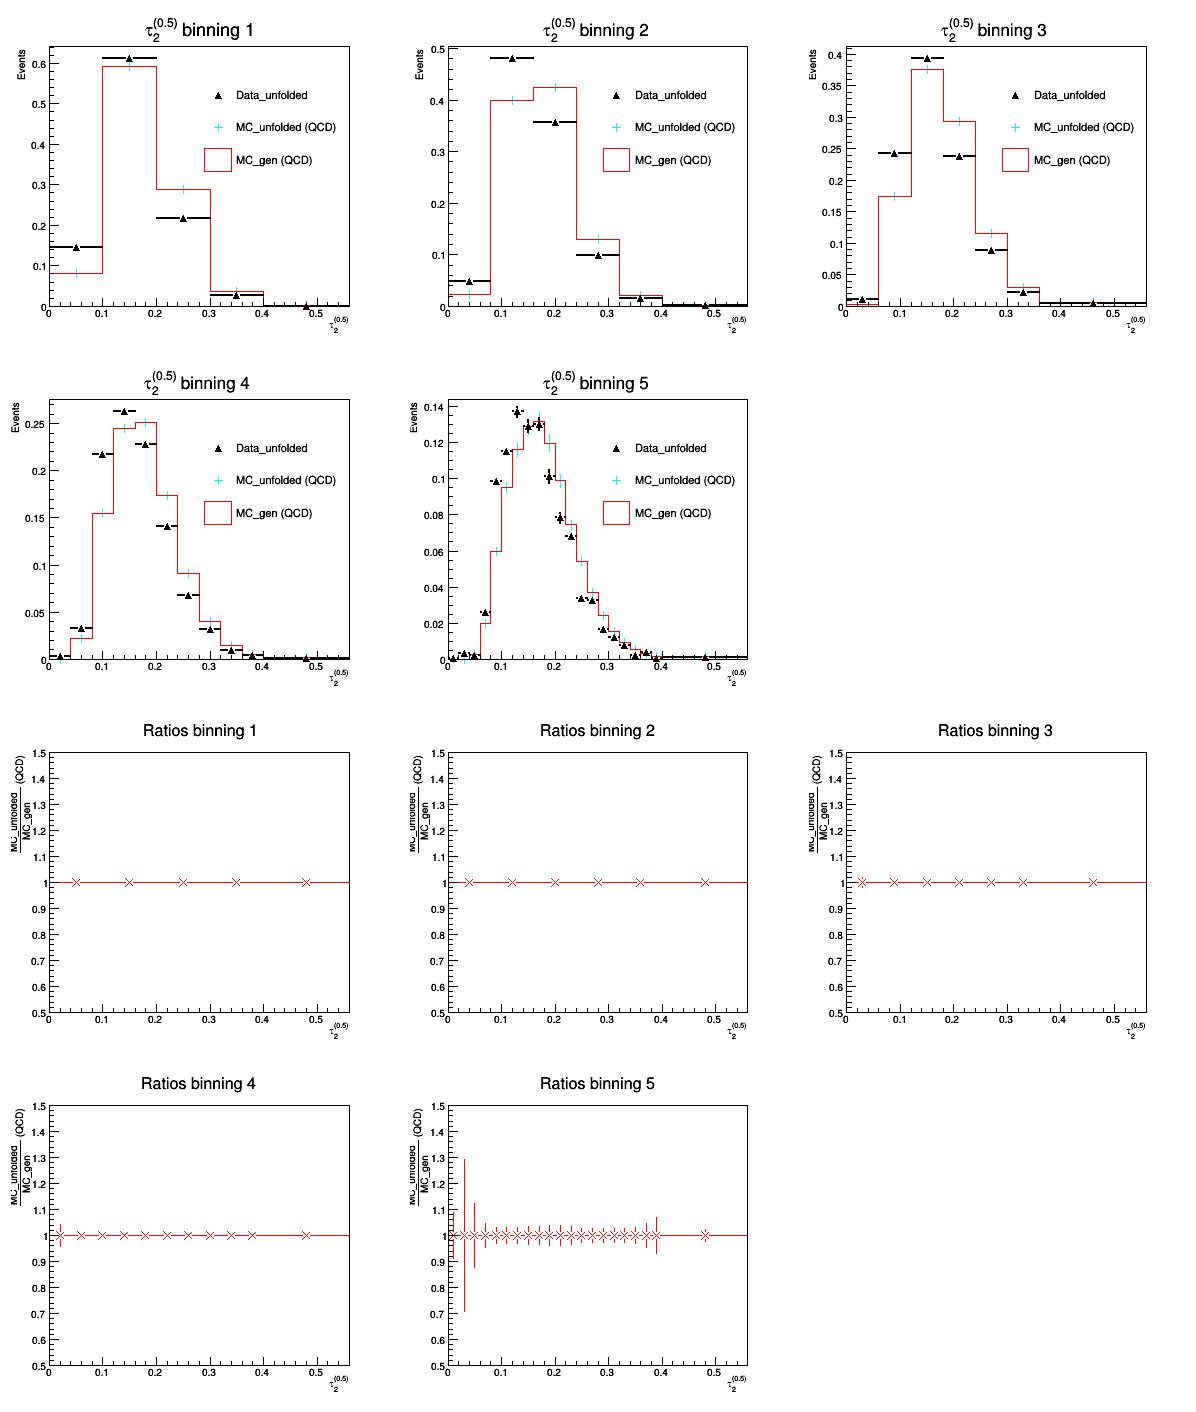

In [15]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

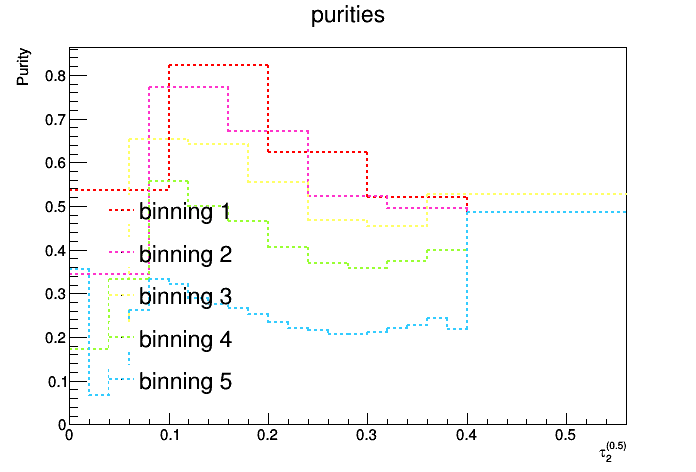

In [16]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

In [ ]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_0p5_2_dijetSel.png has been created
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_0p5_2_dijetSel.png has been created


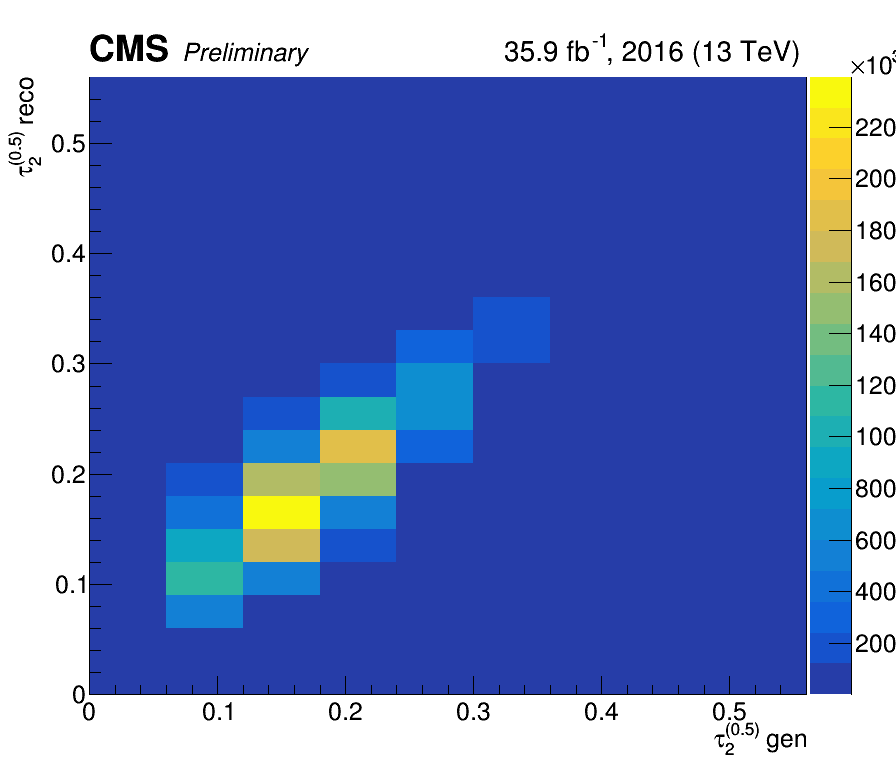

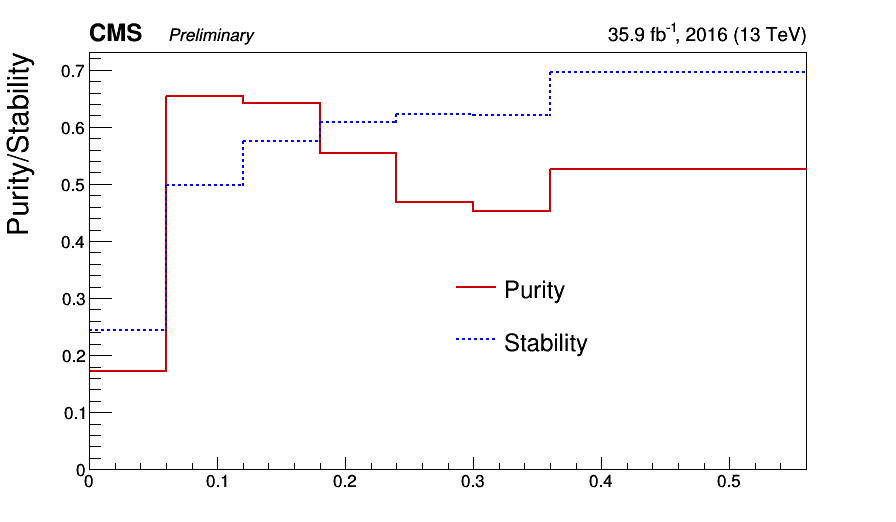

In [19]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_{3}^{(1)}$

In [20]:
reco='recoJet_tau_1_2_nom_dijetSel'
gen='genJet_tau_1_2_dijetSel'
response='respJet_tau_1_2_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


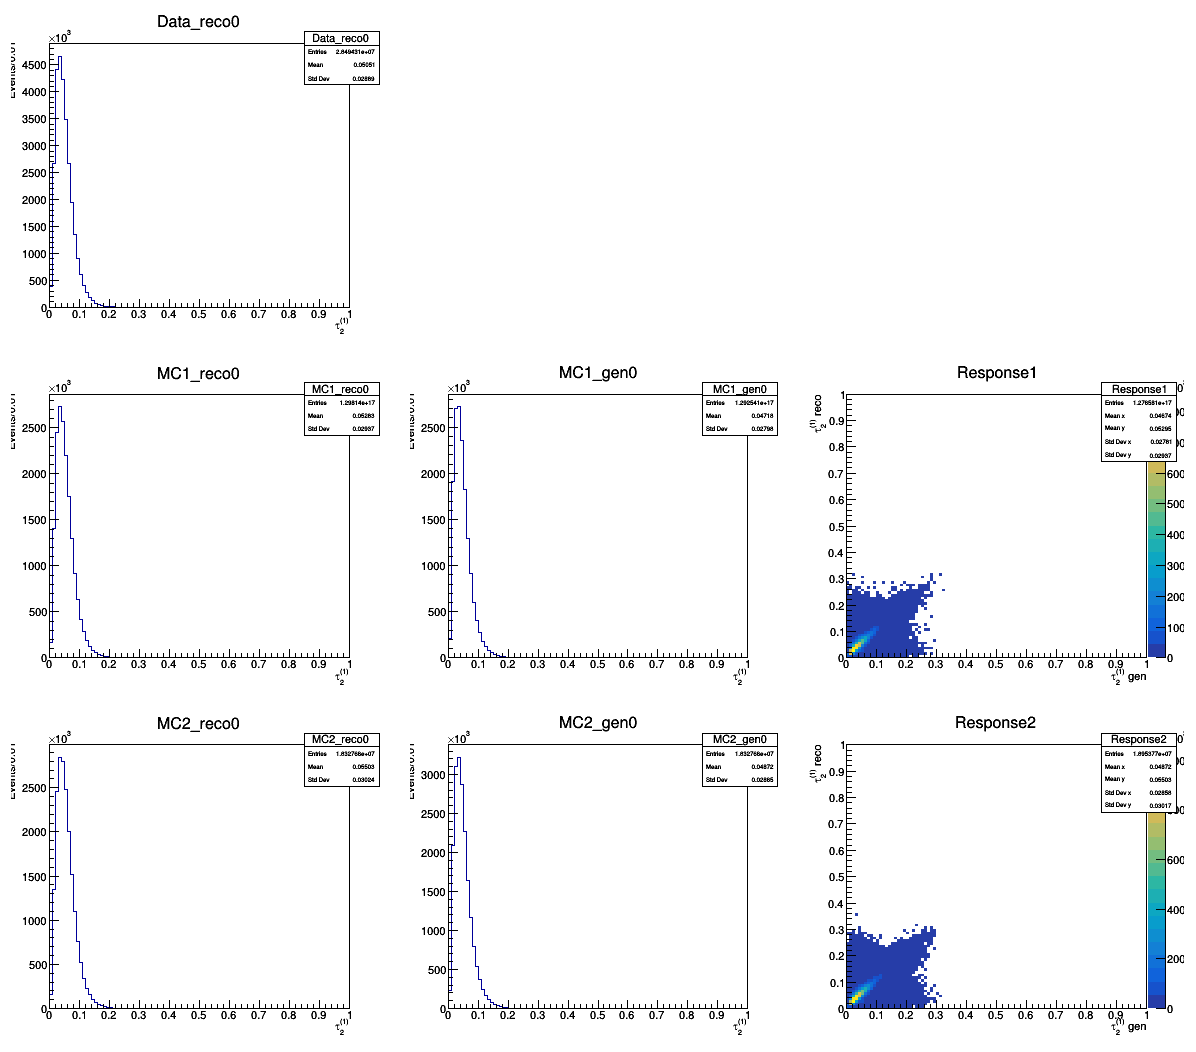

In [21]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(1)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [22]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 230632.350032 164353.151749
0.015 2091172.90364 1353008.63805
0.025 3105706.58085 2454564.62661
0.035 3219316.87182 2844913.7783
0.045 2872920.03905 2799737.97553
0.055 2270878.60301 2484841.36367
0.065 1642858.55722 2007038.29604
0.075 1166067.65694 1520158.96763
0.085 797830.395097 1097970.02909
0.095 537572.902173 762474.879733
0.105 366675.637308 522379.514252
0.115 241208.228908 343522.087315
0.125 163929.495842 226193.487383
0.135 109317.038685 155574.006977
0.145 74342.1508935 103586.116195
0.155 52706.9551024 71700.7309652
0.165 34503.1221129 43587.310316
0.175 21305.5468092 29605.6906961
0.185 14556.1387963 19341.0450529
0.195 9017.38051306 11869.9315945
0.205 6403.10245849 8903.2733578
0.215 3197.36229971 4799.4350037
0.225 2090.216572 2901.61886733
0.235 1115.3229352 1778.16164107
0.245 655.580832509 877.885694327
0.255 266.692604808 432.295831299
0.265 358.833524607 293.94034147
0.275 175.62670921 276.81627548
0.285 12.1255012289 96.9617344791
0.295 8.84370484715 13.1

In [23]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.18)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.32])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.18)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.25,0.32])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.2)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.32])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.2)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.26,0.32])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.2)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.32])))
reco_bins1=np.array([x for x in np.linspace(num=21,start=0.,stop=0.2)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.26,0.32])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.06 0.12 0.18 0.32] 4
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.25 0.32] 8
[0.   0.04 0.08 0.12 0.16 0.2  0.32] 6
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.26 0.32] 12
0.0,0.04,0.08,0.12,0.16,0.2,0.32
0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.26,0.32
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.32] 11
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.26 0.32] 22


In [24]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(1)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(1)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(1)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.06 0.12 0.18 0.32]
for binning 2
[0.   0.04 0.08 0.12 0.16 0.2  0.32]
for binning 3
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.32]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{2}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


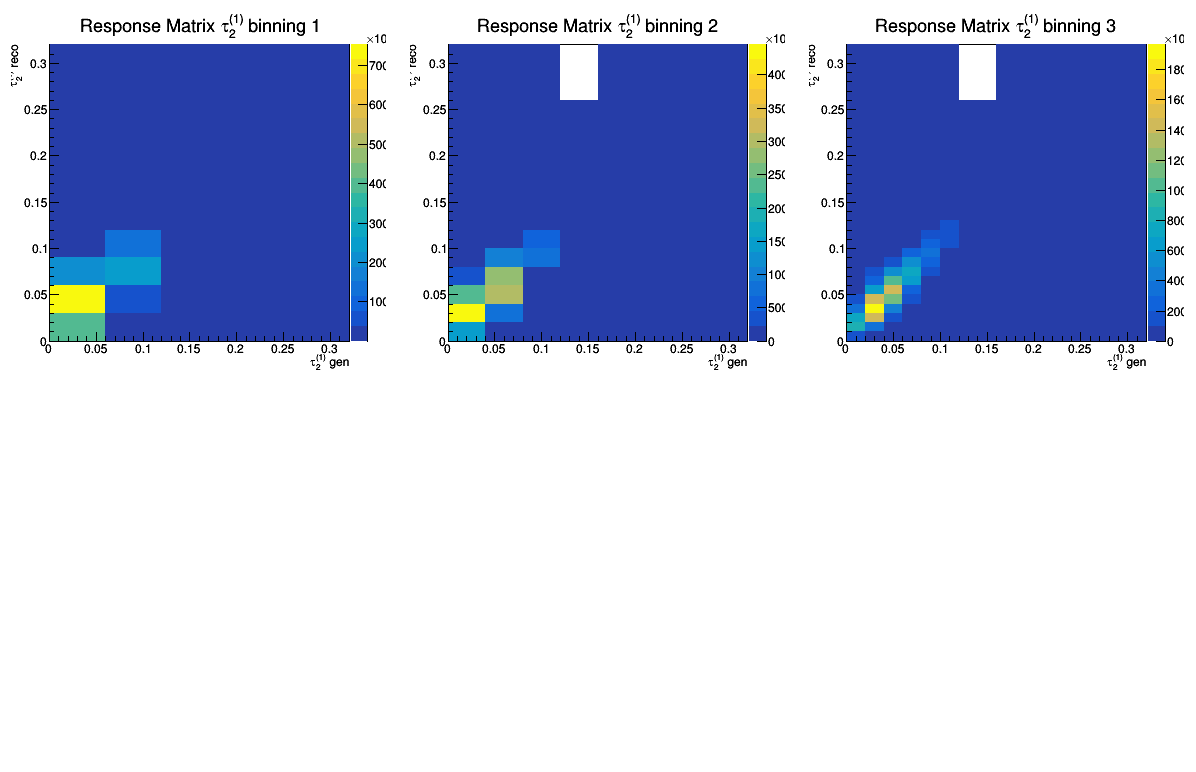

In [25]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


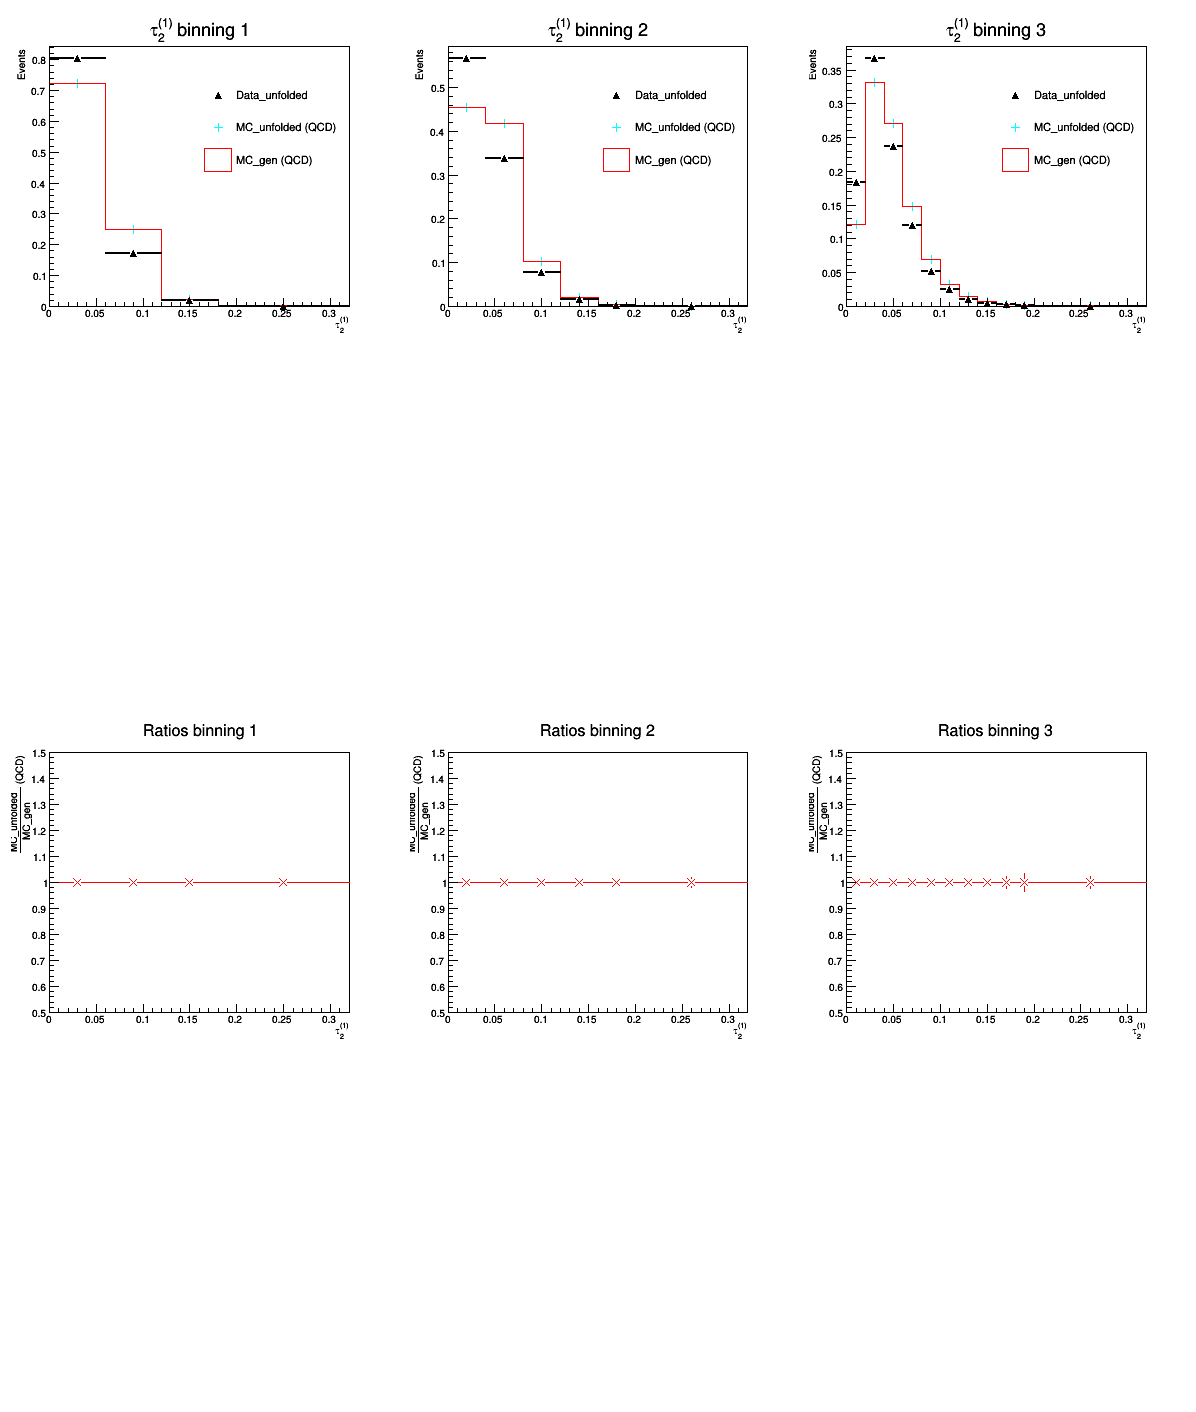

In [26]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

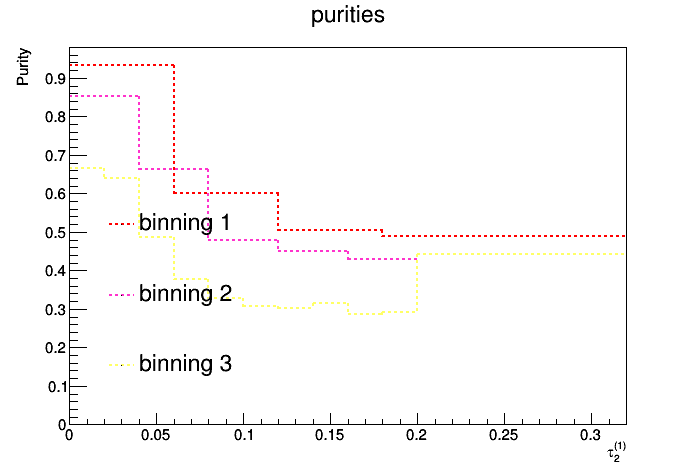

In [27]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

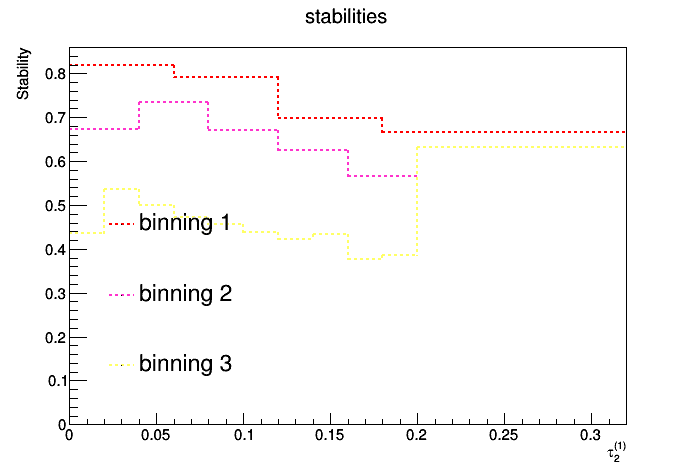

In [28]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_1_2_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_1_2_dijetSel.png has been created


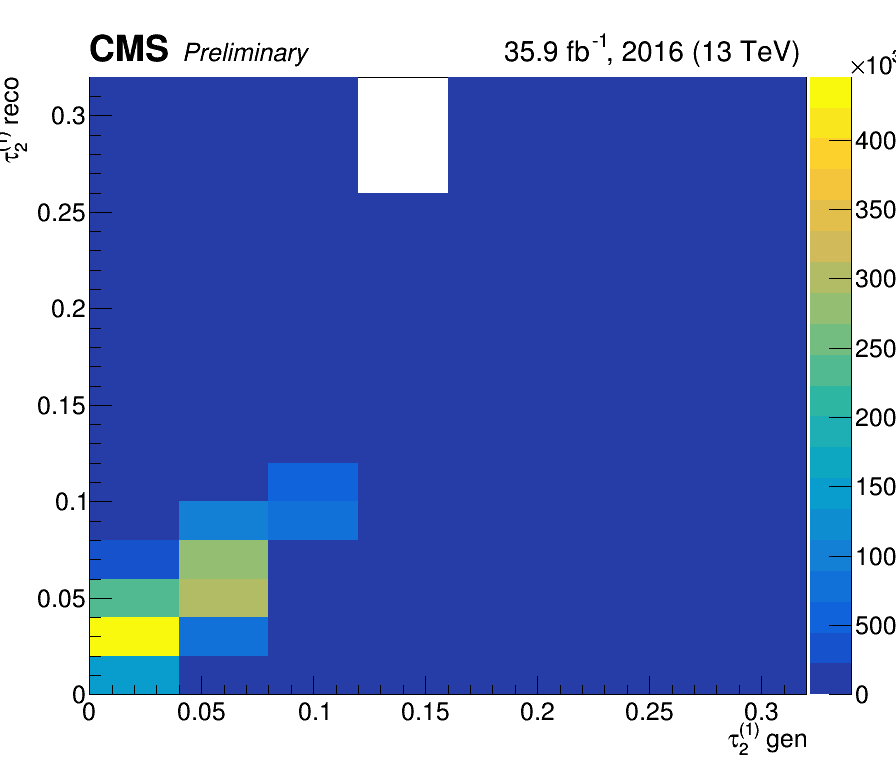

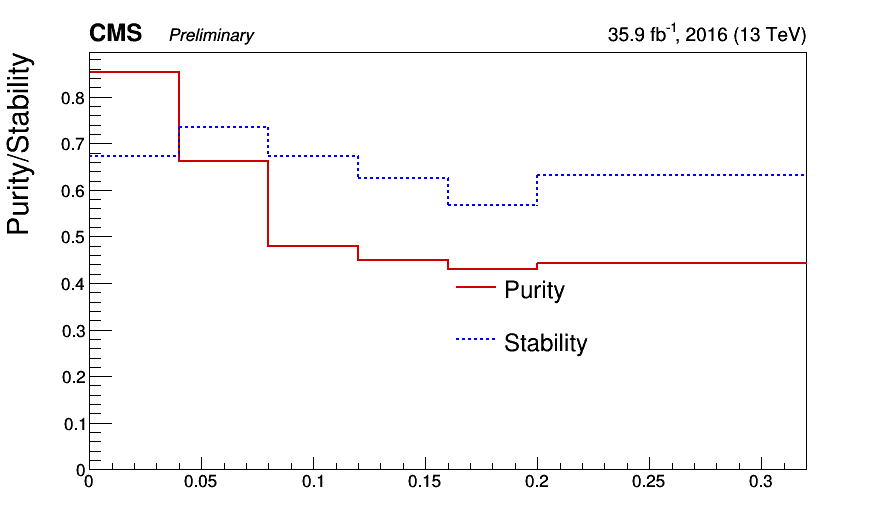

In [29]:
i=1
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_3^{(2)}$

In [30]:
reco='recoJet_tau_2_2_nom_dijetSel'
gen='genJet_tau_2_2_dijetSel'
response='respJet_tau_2_2_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


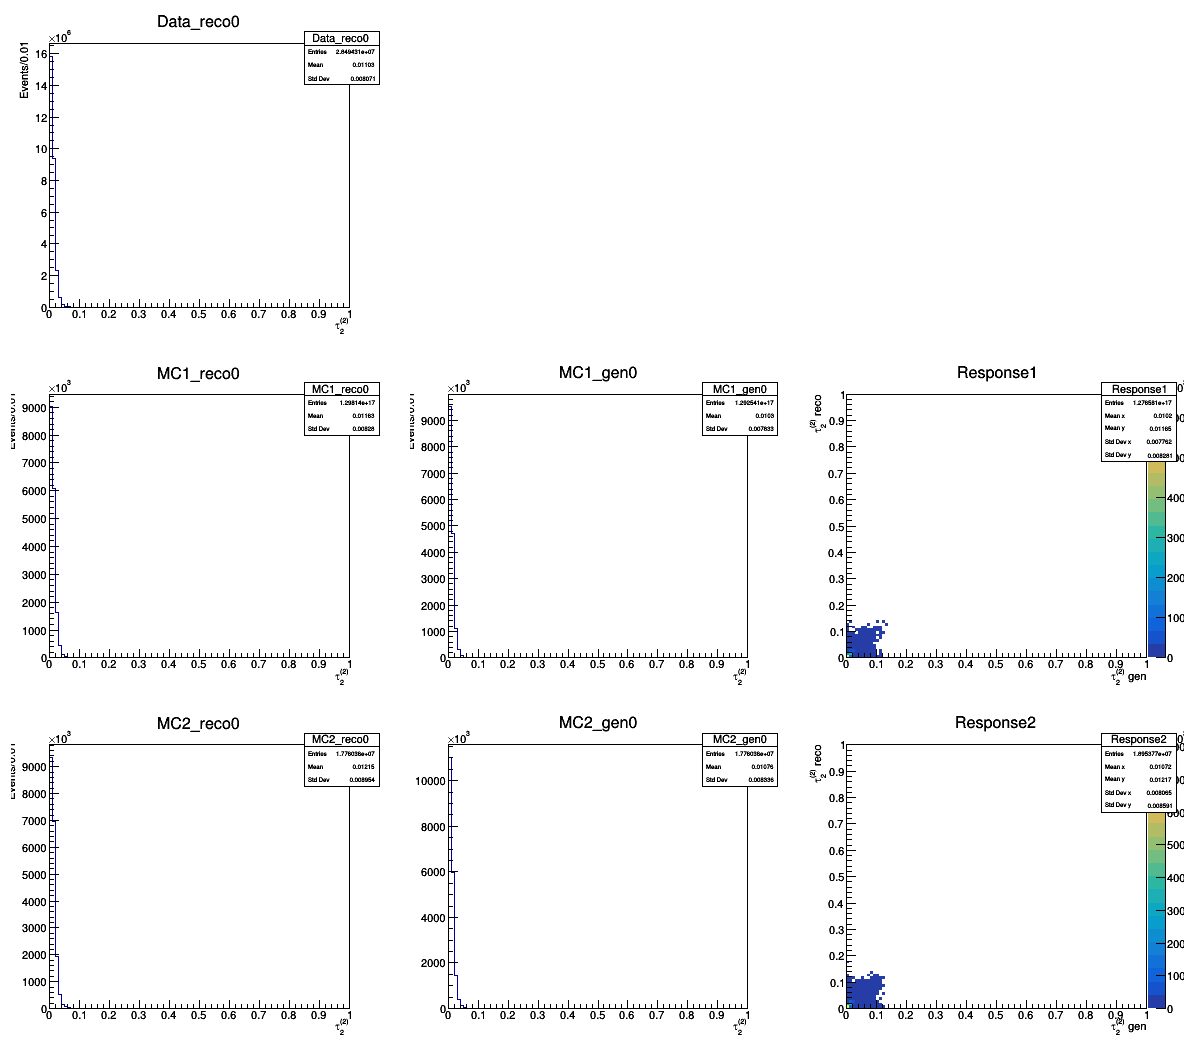

In [31]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [32]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 11025128.217 9345505.38338
0.015 5960265.17924 6960052.24535
0.025 1456407.20375 1939674.15286
0.035 394694.299827 534804.763911
0.045 129738.419271 167936.326461
0.055 48680.8055509 56518.4291226
0.065 13260.634935 20488.7456996
0.075 5032.29233059 7326.10816549
0.085 2455.31788676 3218.01996173
0.095 730.802646624 643.672271043
0.105 264.532554324 403.034874615
0.115 19.3492884977 95.4326418795
0.125 4.85800699485 10.0511614781
0.135 0.0 2.62881383127
0.145 0.0 0.0
0.155 0.0 0.0
0.165 0.0 0.0
0.175 0.0 2.917646271
0.185 0.0 0.0
0.195 0.0 0.0
0.205 0.0 0.0
0.215 0.0 0.0
0.225 0.0 0.0
0.235 0.0 0.0
0.245 0.0 0.0
0.255 0.0 0.0
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.355 0.0 0.0
0.365 0.0 0.0
0.375 0.0 0.0
0.385 0.0 0.0
0.395 0.0 0.0
0.405 0.0 0.0
0.415 0.0 0.0
0.425 0.0 0.0
0.435 0.0 0.0
0.445 0.0 0.0
0.455 0.0 0.0
0.465 0.0 0.0
0.475 0.0 0.0
0.485 0.0 0.0
0.495 0.0 0.0
0.505 0.0 0.0
0.515 0.0 

In [41]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.08)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.14])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.08)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.11,0.14])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.06)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.14])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.06)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.10,0.14])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.04 0.08 0.14] 3
[0.   0.02 0.04 0.06 0.08 0.11 0.14] 6
[0.   0.02 0.04 0.06 0.14] 4
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.14] 8
0.0,0.02,0.04,0.06,0.14
0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.14


In [34]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(2)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(2)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.04 0.08 0.14]
for binning 2
[0.   0.02 0.04 0.06 0.14]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:#tau_{2}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


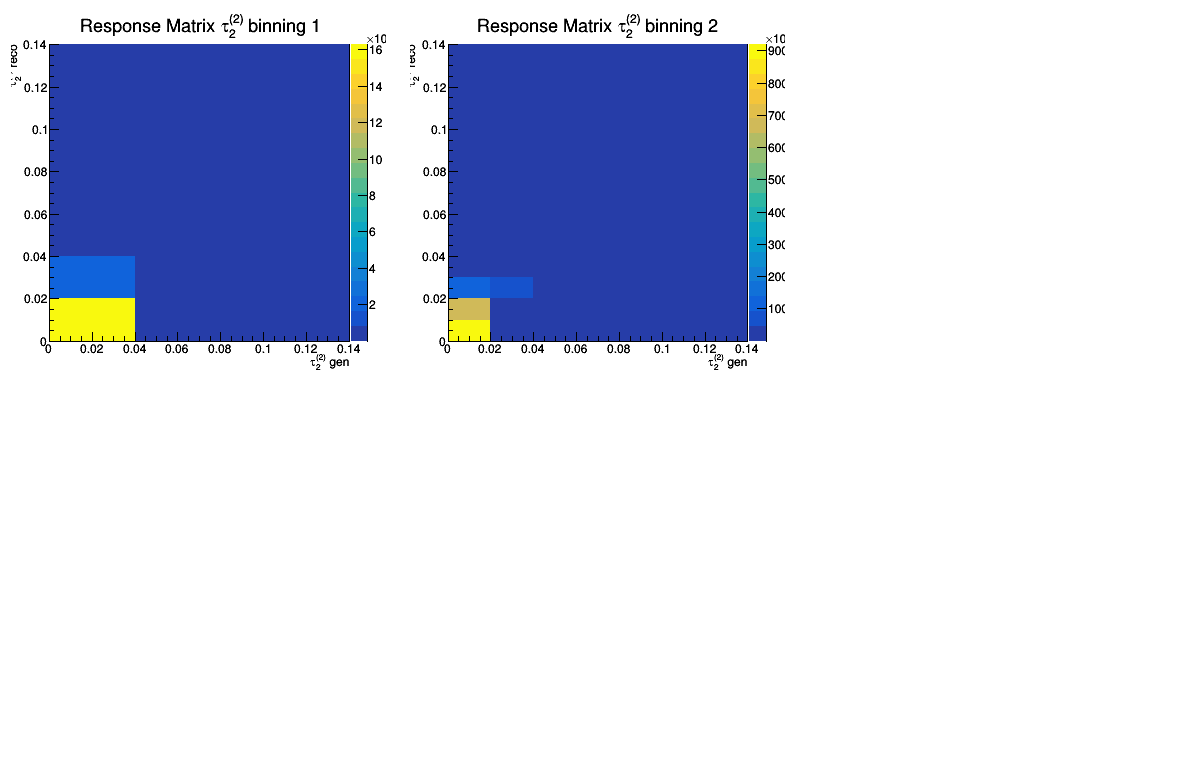

In [35]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


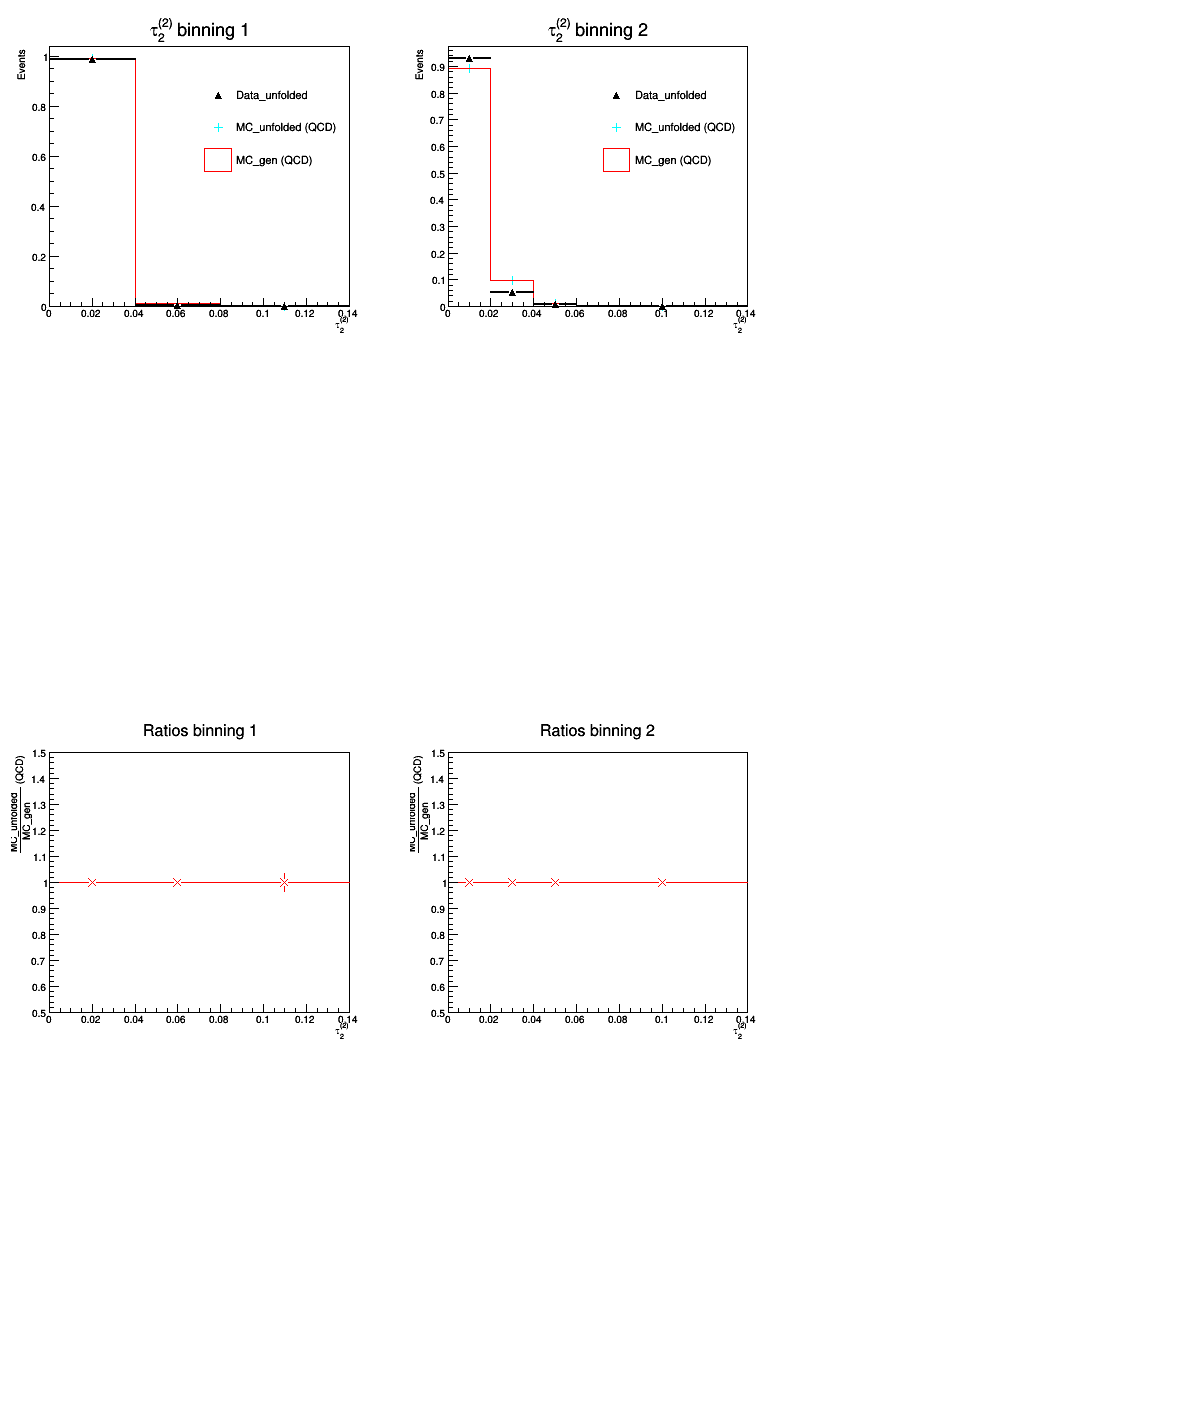

In [36]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

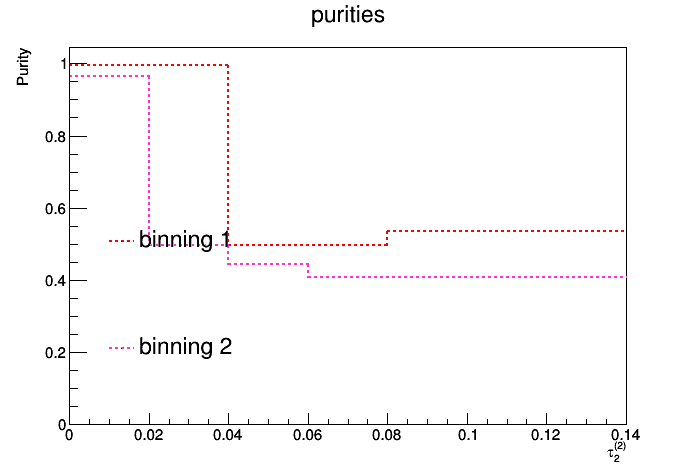

In [37]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

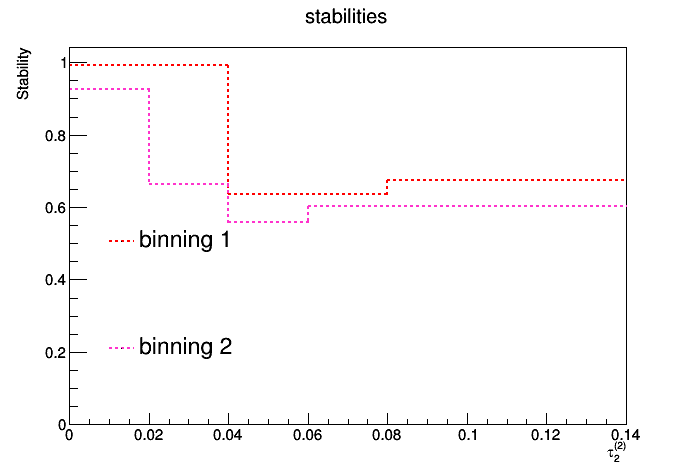

In [38]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_2_2_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_2_2_dijetSel.png has been created


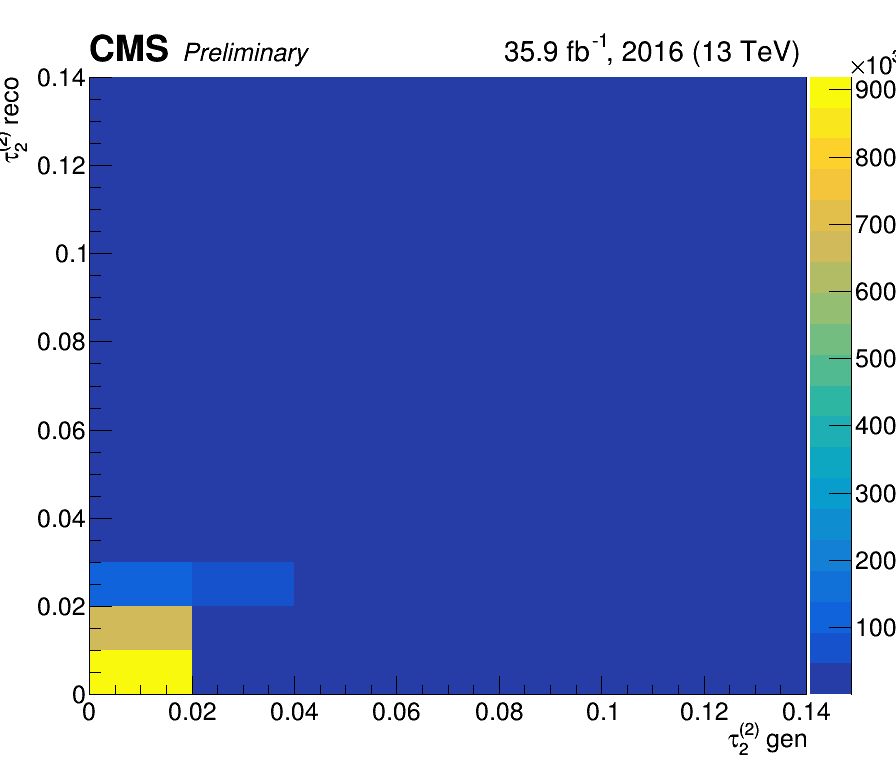

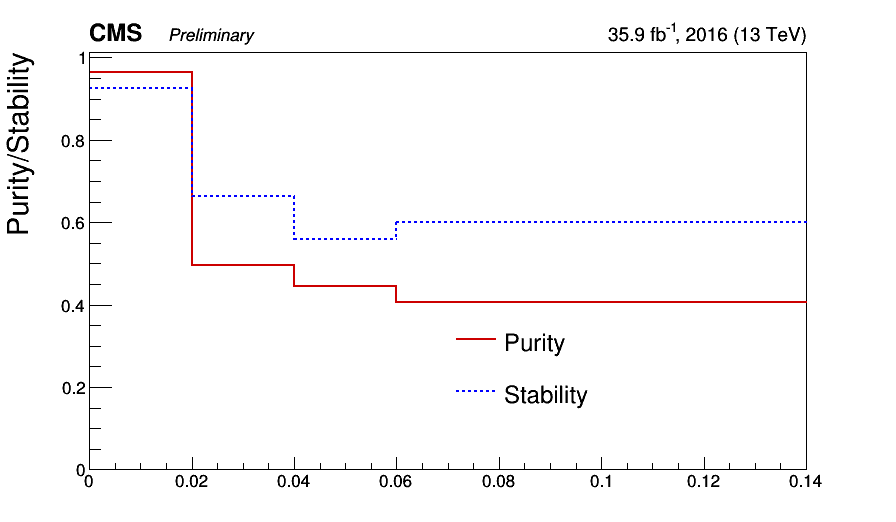

In [40]:
i=1
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.2,0.75,0.4)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')